In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import loadGeographicData

In [2]:
DIST_THREHOLD = 4700

# CYCLE = 8820
# DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
DOWNSAMPLING = 1

In [3]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [4]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [5]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

In [6]:
def geneate_input_filename(date, cycle):

    filename = cfg["paths"]["ark"]["consolidated-long-haul-explorations"].format(date, cycle, DOWNSAMPLING)

    # filenames._create_dir(filename)
    return filename

In [7]:
def unwrap_lon(x):
    if x < 40:
        return  x

    return -360 + x

In [8]:
lhl_d = {}

# for date, cycle in [(20201002, 8820), (20201002, 8821), (20201002, 8822),]:
# for date, cycle in [(20201002, 8820), (20201002, 8821), (20201002, 8822),]:
for date, cycle in [(20220501, 10019), (20220501, 10020), (20220502, 10021),]:
    lhl_d[cycle] = pd.read_csv(geneate_input_filename(date, cycle),
                               compression="bz2")
    lhl_d[cycle]["mpls_tunnel"] = lhl_d[cycle]["mpls_tunnel"].astype(bool)

In [9]:
cepii = loadGeographicData.load_inter_country_distances("data/external/cepii/dist_cepii.csv", 
                                                        "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


In [10]:
filtered_geoloc_hops = {}

for cycle in lhl_d.keys():
    filtered_geoloc_hops[cycle] = lhlFilters.filter_with_cepii(cepii, lhlFilters.find_min_rtt(lhl_d[cycle]))

In [11]:
# for cycle in [8821,]:
for cycle in [10020,]:
    concat_df = pd.DataFrame()
    for _cycle in range(cycle -1, cycle + 2):
        # concat_df = concat_df.append(filtered_geoloc_hops[_cycle])
        concat_df = pd.concat([concat_df, filtered_geoloc_hops[_cycle]])

# for cycle in [8821,]:
#     concat_df = pd.DataFrame()
#     for _cycle in range(cycle -1, cycle + 2):
#         concat_df = concat_df.append(g[_cycle])

df = concat_df

In [12]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)

In [13]:
all_vals = []
cc_list = []
rtt_vals = []
for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]
    cc_str_1 = f"{cc1}-{cc2}"
    cc_str_2 = f"{cc2}-{cc1}"
    if (cc_str_1 not in cc_list) and (cc_str_2 not in cc_list):
        cc_list.append(cc_str_1)
    rtt_vals.append(weight["diff_rtt"])
    all_vals.append((cc1, cc2, weight["diff_rtt"]))

In [14]:
l = []

for str_cc in cc_list:
    cc1, cc2 = str_cc.split("-")
    l.append((cc1, cc2))

cc_graph = pd.DataFrame(l, columns=["cc1", "cc2"])
cc_graph = cc_graph.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
cc_graph.head()


,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219


In [15]:
all_vals = pd.DataFrame(all_vals, columns=["cc1", "cc2", "diff_rtt"])
all_vals = all_vals.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
all_vals.head()

,cc1,cc2,diff_rtt,dist
0,AE,CH,114.876,4407.826551
1,CH,JP,209.294,9214.366906
2,CH,JP,211.329,9214.366906
3,AE,DE,67.622,4266.720006
4,DE,US,80.180,5297.217204


In [16]:
H = nx.from_pandas_edgelist(
   cc_graph,
    "cc1",
    "cc2",
)

print(f"nodes: {len(G.nodes())}")
print(f"edges: {len(G.edges())}")
print(f"countries: {len(H.nodes())}")



nodes: 31773
edges: 85620
countries: 170


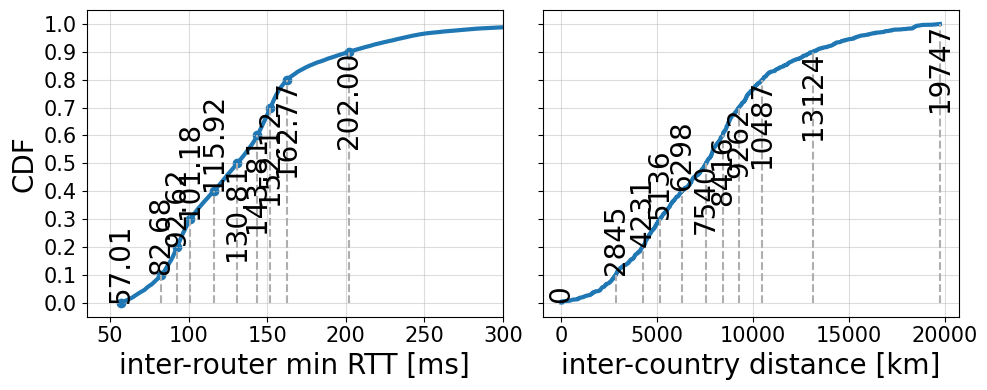

In [17]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax1.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')



x, y = ecdf(pd.DataFrame(rtt_vals, columns=["rtt"])["rtt"])
# ax.plot(x, 1- y, label=f"X", lw=3)
ax1.plot(x, y, label=f"X", lw=3)


ax1.scatter(
    np.percentile(rtt_vals, np.arange(0, 100.1, 10)),
    np.arange(0, 1.01, 0.1)
)

for x, y in zip(np.percentile(rtt_vals, np.arange(0, 100.1, 10)),
                np.arange(0, 1.01, 0.1)):
    ax1.plot(
        [x, x],
        [0, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    if y < 0.5:
        v = "bottom"
    else:
        v = "top"

    ax1.annotate(
        f"{x:.2f}",
        (x, y),
        fontsize=20,
        color="black",
        va=v,
        ha="center",
        rotation=90
    )

ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.set_ylabel('CDF', fontsize=20)
ax1.set_xlabel('inter-router min RTT [ms]', fontsize=20)
ax1.tick_params(labelsize=15)
ax1.set_xlim(35, 300)


#

ax2.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax2.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')



x, y = ecdf(cc_graph["dist"])
# ax.plot(x, 1- y, label=f"X", lw=3)
ax2.plot(x, y, label=f"X", lw=3)


for x, y in zip(np.percentile(cc_graph["dist"].values, np.arange(0, 100.1, 10)),
                np.arange(0, 1.01, 0.1)):
    ax2.plot(
        [x, x],
        [0, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    if y < 0.5:
        v = "bottom"
    else:
        v = "top"

    ax2.annotate(
        f"{x:.0f}",
        (x, y),
        fontsize=20,
        color="black",
        va=v,
        ha="center",
        rotation=90
    )

ax2.set_xlabel('inter-country distance [km]', fontsize=20)
# ax.set_title('far-side RTT', fontsize=20)
ax2.tick_params(labelsize=15)

fig.subplots_adjust(hspace=0)
fig.tight_layout()



# fig.savefig("figures/ulh-prevalence/router_level_rtt_dist_and_cc_dist.pdf")

In [18]:
G0 = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [19]:
G1 = nx.from_pandas_edgelist(
   df,
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [20]:
len(G0.edges())

85620

In [21]:
len(G1.edges())

85620

In [22]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)


In [23]:

hits = {}

for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]

    cc1_3 = pc.countries.get(alpha_2=cc1).alpha_3
    cc2_3 = pc.countries.get(alpha_2=cc2).alpha_3

    if cc1_3 not in hits.keys():
        hits[cc1_3] = 0
    if cc2_3 not in hits.keys():
        hits[cc2_3] = 0

    hits[cc1_3] += 1
    hits[cc2_3] += 1

In [24]:
cc3_edges = pd.DataFrame(hits.items(), columns = ["iso_a3", "cnt"])
cc3_edges.head()

,iso_a3,cnt
0,ARE,141
1,CHE,1339
2,JPN,1497
3,DEU,30906
4,USA,68432


/tmp/ipykernel_563323/2182717538.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  world_colors = matplotlib.cm.get_cmap('turbo')
/tmp/ipykernel_563323/2182717538.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.8/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/tmp/ipykernel_563323/2182717538.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


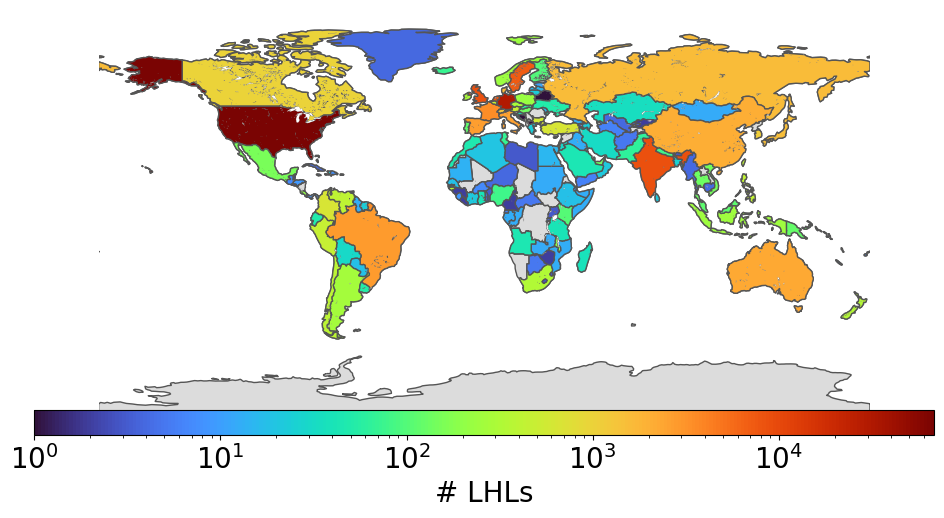

In [25]:
world_colors = matplotlib.cm.get_cmap('turbo')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
lakes = gpd.read_file("data/external/ne_10m_lakes/ne_10m_lakes.shx")

# Manual fixing
# https://github.com/geopandas/geopandas/issues/1041
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'


world = world.join(
    cc3_edges.set_index(["iso_a3", ]),
    on=["iso_a3", ],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)

cc3_list = []
for idx, row in cc_graph.iterrows():
    cc3_list.append(pc.countries.get(alpha_2=row["cc1"]).alpha_3)
    cc3_list.append(pc.countries.get(alpha_2=row["cc2"]).alpha_3)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0.05, 0.15, 0.9, 0.85], frameon=False)

world.plot(color='#dcdcdc', edgecolor='#555555', ax=ax)
world.plot(column="cnt",

    norm=colors.LogNorm(
        vmin=cc3_edges["cnt"].min(),
        vmax=cc3_edges["cnt"].max()
    ),
    cmap=world_colors,
    alpha=1,
    edgecolor='#555555',
    ax=ax)
lakes.plot(column='geometry', color='white', edgecolor='#555555', ax=ax, lw=0.1)


ax.set_xlim(-180, 180)
ax.axis('off')

cax0 = fig.add_axes([0.05, 0.15, 0.9, 0.05])
sm = cm.ScalarMappable(
    cmap=world_colors,
    norm=colors.LogNorm(
        vmin=cc3_edges["cnt"].min(),
        vmax=cc3_edges["cnt"].max()
    ),
)
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cbar = fig.colorbar(sm, cax=cax0, orientation='horizontal')
# cbar.set_hatch(hatchs[0])
cax0.tick_params(labelsize=20)
cax0.set_xlabel('# LHLs', fontsize=20)

# fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/ulh-prevalence/countries_with_lhl_colors.pdf")

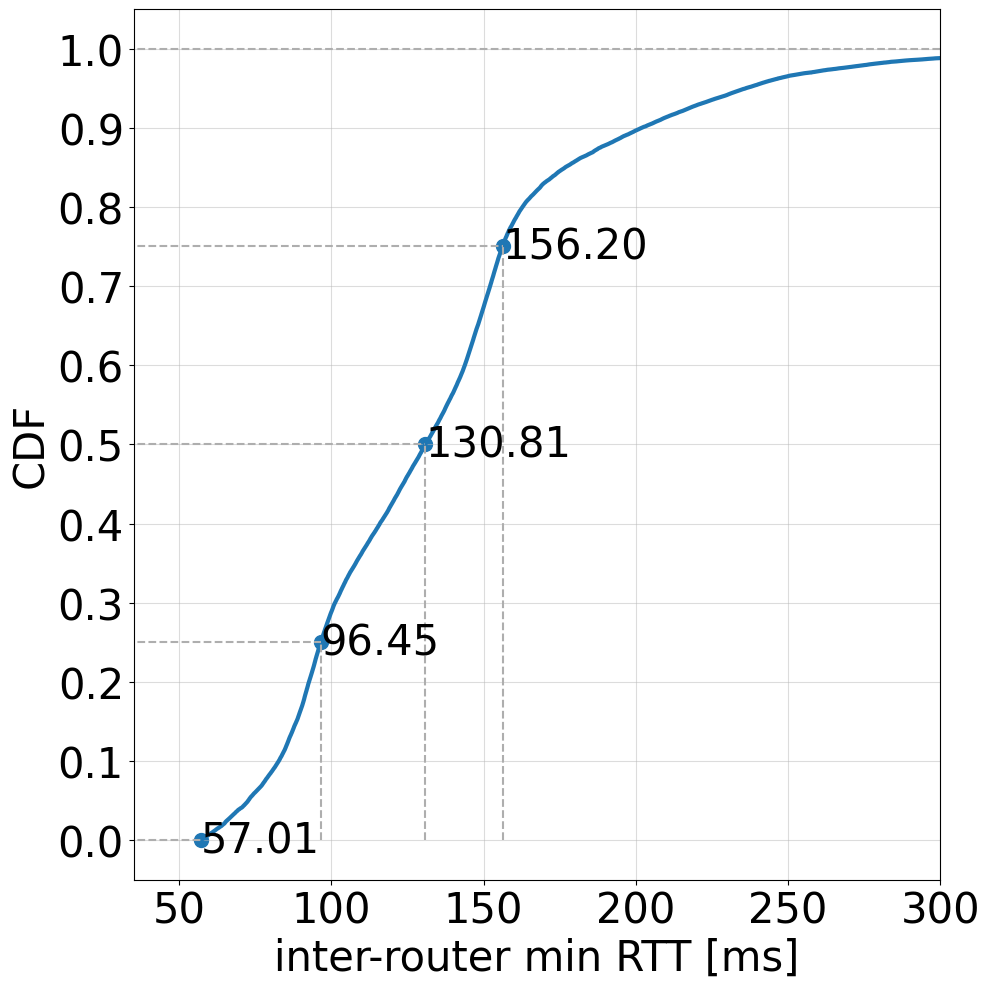

In [26]:
fig, ax1 = plt.subplots(1, figsize=(10, 10), sharey=True)

ax1.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax1.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')



x, y = ecdf(pd.DataFrame(rtt_vals, columns=["rtt"])["rtt"])
# ax.plot(x, 1- y, label=f"X", lw=3)
ax1.plot(x, y, label=f"X", lw=3)


ax1.scatter(
    np.percentile(rtt_vals, np.arange(0, 100.1, 25)),
    np.arange(0, 1.01, 0.25),
    s=100
)

for x, y in zip(np.percentile(rtt_vals, np.arange(0, 100.1, 25)),
                np.arange(0, 1.01, 0.25)):
    ax1.plot(
        [x, x],
        [0, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    ax1.plot(
        [0, x],
        [y, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    ax1.annotate(
        f"{x:.2f}",
        (x, y),
        fontsize=30,
        color="black",
        va="center",
        ha="left",
        rotation=00
    )

ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.set_ylabel('CDF', fontsize=30)
ax1.set_xlabel('inter-router min RTT [ms]', fontsize=30)
ax1.tick_params(labelsize=30)
ax1.set_xlim(35, 300)


fig.subplots_adjust(hspace=0)
fig.tight_layout()

# fig.savefig("figures/ulh-prevalence/router_level_rtt_dist_2.pdf")

In [27]:
r = pd.DataFrame(rtt_vals, columns=["rtt"])["rtt"]

In [28]:
r[(r > 50) & (r < 135)].size / r.size

0.5274468582106985

In [29]:
np.percentile(r, [90,])

array([202.0005])

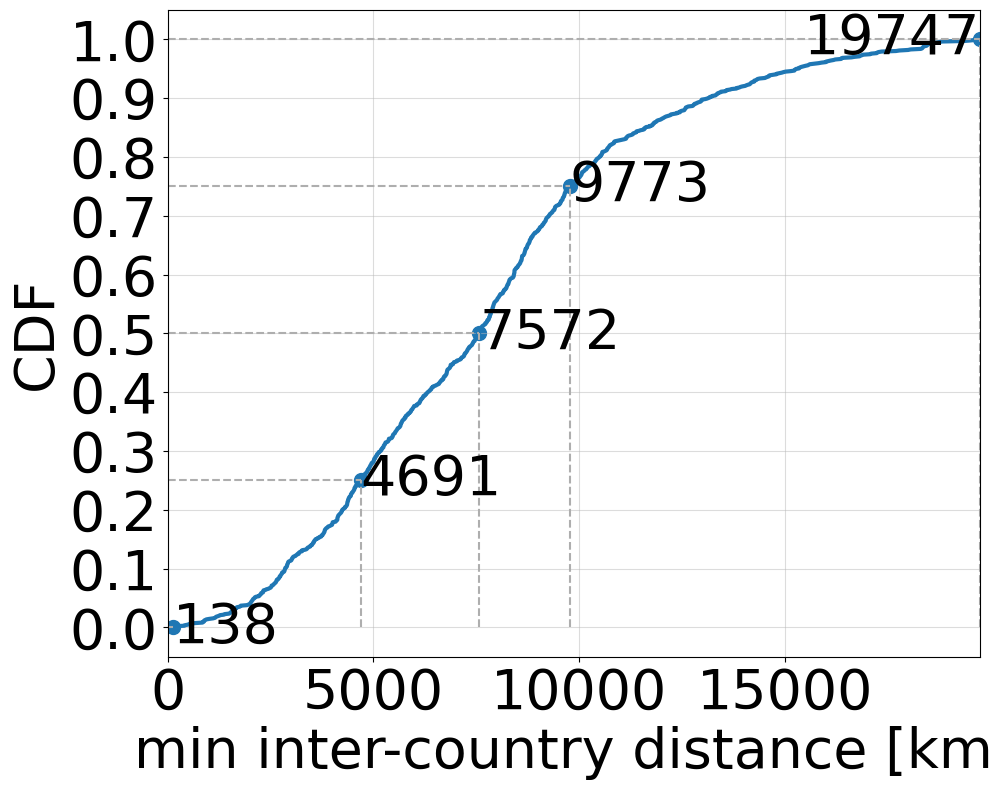

In [30]:
fig, ax1 = plt.subplots(1, figsize=(10, 8), sharey=True)

ax1.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax1.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')




x, y = ecdf(cc_graph.loc[cc_graph["dist"] > 0]["dist"])
# ax.plot(x, 1- y, label=f"X", lw=3)
ax1.plot(x, y, label=f"X", lw=3)


ax1.scatter(
    np.percentile(cc_graph.loc[cc_graph["dist"] > 0]["dist"], np.arange(0, 100.1, 25)),
    np.arange(0, 1.01, 0.25),
    s=100
)

for x, y in zip(np.percentile(cc_graph.loc[cc_graph["dist"] > 0]["dist"], np.arange(0, 100.1, 25)),
                np.arange(0, 1.01, 0.25)):
    ax1.plot(
        [x, x],
        [0, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    ax1.plot(
        [0, x],
        [y, y],
        linestyle="dashed",
        color="#aeaeae"
    )

    if y == 1:
        pose = "right"
    else:
        pose = "left"

    ax1.annotate(
        f"{int(x):d}",
        (x, y),
        fontsize=40,
        color="black",
        va="center",
        ha=pose,
        rotation=00
    )

ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.set_ylabel('CDF', fontsize=40)
ax1.set_xlabel('min inter-country distance [km]', fontsize=40)
ax1.tick_params(labelsize=40)
ax1.set_xlim(min(cc_graph["dist"]), max(cc_graph["dist"]))


fig.subplots_adjust(hspace=0)
fig.tight_layout()



# fig.savefig("figures/ulh-prevalence/router_level__cc_dist_2.pdf")

In [31]:
cc_graph.loc[cc_graph["dist"] > 1600].sort_values("dist")

,cc1,cc2,dist
221,TR,FR,1624.218125
429,BR,DO,1624.244730
54,CR,BR,1625.812472
16,US,CO,1671.006273
729,IL,IT,1679.876822
...,...,...,...
632,PE,SG,18825.880000
605,CO,SG,19364.400000
68,ID,CO,19515.576477
1108,KR,UY,19629.500000


In [32]:
d = cc_graph.loc[cc_graph["dist"] > 0]["dist"]

In [33]:
np.percentile(d, [90,])

array([13140.12530378])

In [34]:
cc_graph

,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219
...,...,...,...
1111,SE,BT,6126.209823
1112,SK,GW,4863.081320
1113,UA,GE,420.365010
1114,UA,UZ,1273.707974


In [35]:
def fix(x, y):
    d0 = y - x
    d1 = (180 - abs(y)) + (180 - abs(x))

    if d0 < d1:
        return [(x, y),]
    elif y > x:
        return [(x, -180 - (180 - y)), (180 + (180 + x), y)]
    else:
#         return x, 180 + (180 + y)
        return [(x, 180 + (180 + y)), (-180 - (180 - x), y)]

def unfold(nlon, flon, nlat, flat):
    lons = fix(nlon, flon)

    return lons, [(nlat, flat)] * len(lons)

/tmp/ipykernel_563323/1466937238.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.8/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


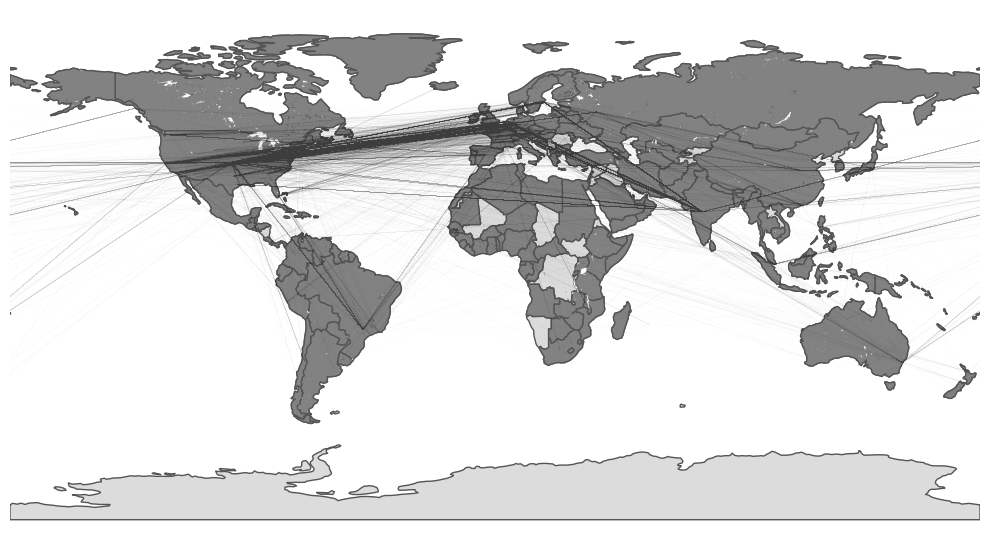

In [36]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
lakes = gpd.read_file("data/external/ne_10m_lakes/ne_10m_lakes.shx")
#
# Manual fixing
# https://github.com/geopandas/geopandas/issues/1041
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

cc3_list = []
for idx, row in cc_graph.loc[cc_graph["dist"] > DIST_THREHOLD].iterrows():
    cc3_list.append(pc.countries.get(alpha_2=row["cc1"]).alpha_3)
    cc3_list.append(pc.countries.get(alpha_2=row["cc2"]).alpha_3)

fig, ax = plt.subplots(1, figsize=(10, 6))

world.plot(color='#dcdcdc', edgecolor='#555555', ax=ax)
world.loc[world["iso_a3"].isin(cc3_list)].plot(color='#828282',
                                               edgecolor='#555555',
                                               ax=ax)
lakes.plot(column='geometry', color='white', edgecolor='#555555', ax=ax, lw=0.1)

sampling = 10
tmp = concat_df.drop_duplicates(["near_node_id", "far_node_id"])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp = tmp[::sampling]
# for idx, row in concat_df.drop_duplicates(["near_node_id", "far_node_id"]).iterrows():
for idx, row in tmp.drop_duplicates(["near_node_id", "far_node_id"]).iterrows():

    # ax.plot([row["near_side_lon"], row["far_side_lon"],],
    #         [row["near_side_lat"], row["far_side_lat"],],
    #         color="k", lw=0.005)

    lons, lats = unfold(row["near_side_lon"], row["far_side_lon"],
                        row["near_side_lat"], row["far_side_lat"])

    for lon, lat in zip(lons, lats):
        ax.plot(
            [lon[0], lon[1]],
            [lat[0], lat[1]],
            color = "#3d3d3d",
            lw=0.01,
            alpha=0.5
        )

ax.set_xlim(-180, 180)
ax.axis('off')

fig.subplots_adjust(hspace=0)
fig.tight_layout()
#
# fig.savefig("figures/ulh-prevalence/countries_with_lhl_with_links_2.pdf")

In [37]:
def _get_cont(cc):
    country = pc.countries.get(alpha_2=cc)
    continent = pcc.country_alpha2_to_continent_code(country.alpha_2)
    
    return continent

def get_cont_pairs(G):

    cont_vals = []

    for n1, n2, weight  in G.edges(data=True):
        cont1 = _get_cont(G.nodes()[n1]["cc"])
        cont2 = _get_cont(G.nodes()[n2]["cc"])
                
        if cont1 > cont2:
            cont1, cont2 = cont2, cont1
            
        cont_str_1 = f"{cont1}-{cont2}"
        
        cont_vals.append(cont_str_1)
    
    return cont_vals


def get_continent_rtts(G, src_cont):
   
    rtt_vals = []
    
    for n1, n2, weight in G.edges(data=True):
        cont1 = _get_cont(G.nodes()[n1]["cc"])
        cont2 = _get_cont(G.nodes()[n2]["cc"])
        
        if cont1 == src_cont or cont2 == src_cont:
                
            if cont1 > cont2:
                cont1, cont2 = cont2, cont1

            cont_str_1 = f"{cont1}-{cont2}"


            rtt_vals.append((cont_str_1, weight["diff_rtt"]))
    
    return rtt_vals

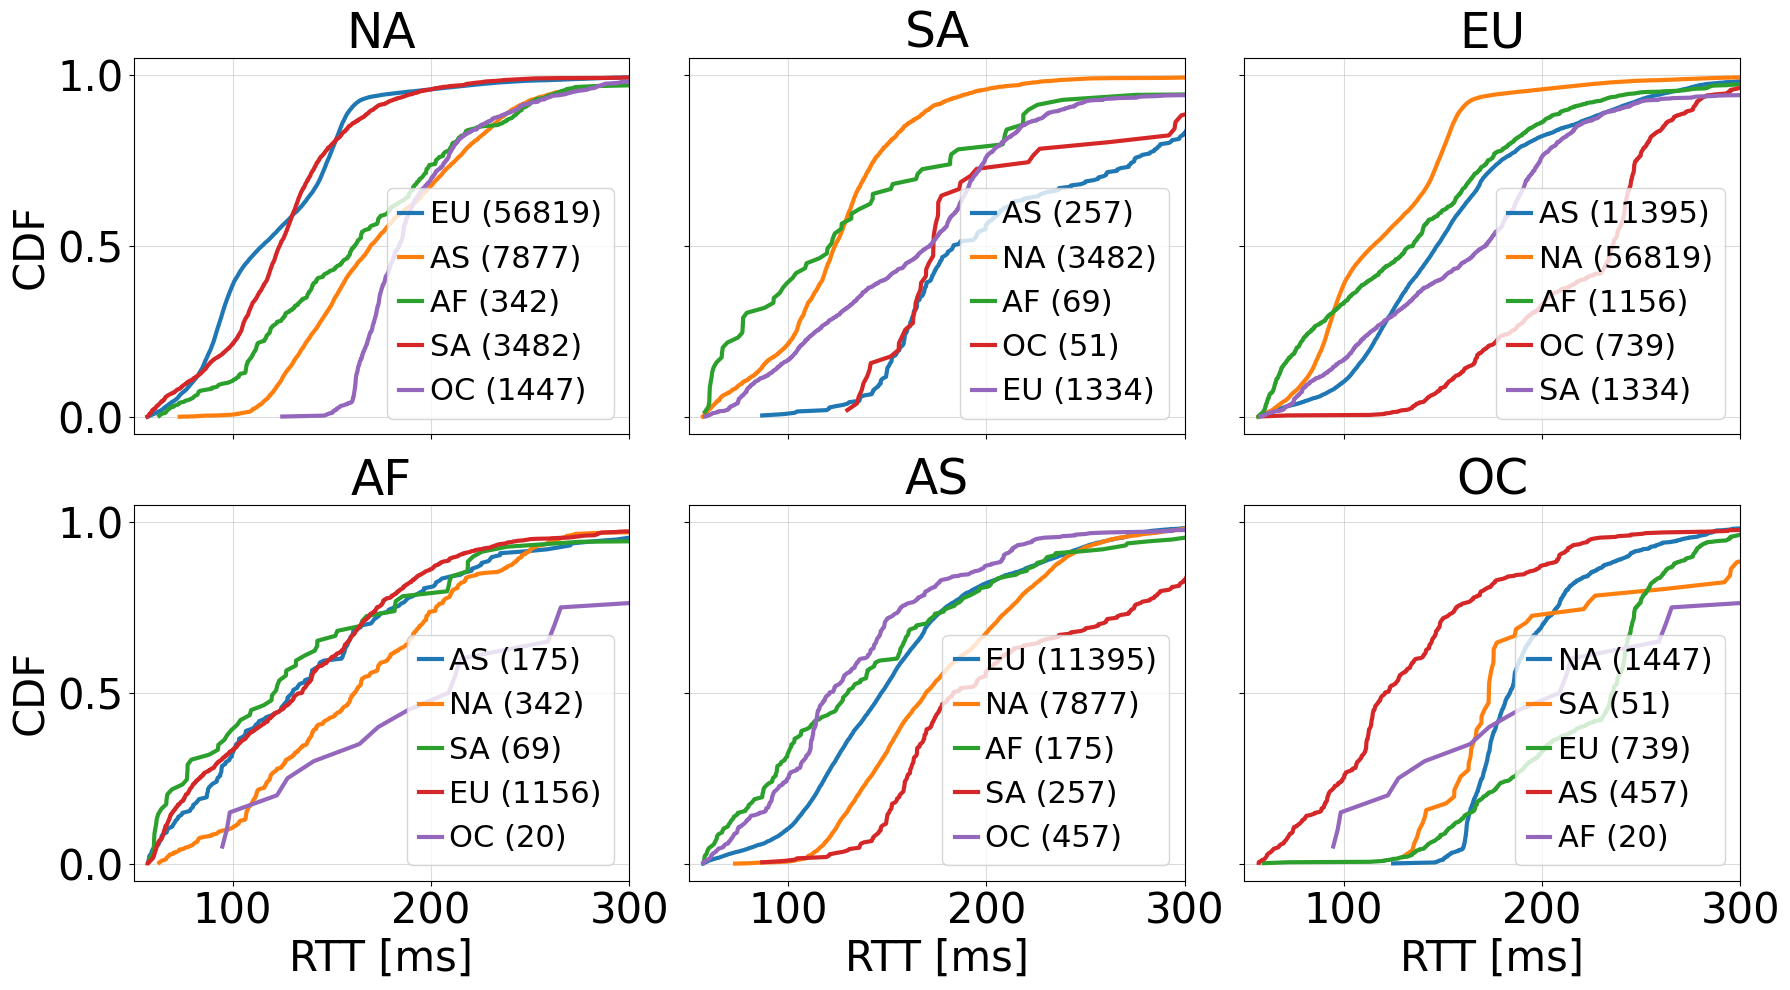

In [38]:
fig, axlist = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

i = 0

# G = lhl_df2graph(all_df)

for src_cont in ["NA", "SA", "EU", "AF", "AS", "OC"]:
    
    ax = axlist[int(i / 3)][i % 3]
    
    ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
    ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')

    markers = itertools.cycle(["o", "d", "s"])
    
    
    
    rtts = get_continent_rtts(G, src_cont)
    df = pd.DataFrame(rtts, columns=["cont", "rtt"])
    

    for cont in df.drop_duplicates("cont")["cont"].values:
    
        x, y = ecdf(df.loc[df["cont"] == cont]["rtt"])
        cont_label = cont.replace(f"-{src_cont}", "").replace(f"{src_cont}-", "")
        ax.plot(x, y, label=f'{cont_label} ({len(x)})', lw=3)
    
    
    ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=22,
              handletextpad=0.25, columnspacing=0.5, handlelength=0.75)
    
    ax.set_title(f"{src_cont}", fontsize=35)

    ax.set_xlim(50, 300)
    
    # ax.set_ylabel('CDF', fontsize=20)
    
    if int(i / 3) == 1:
        ax.set_xlabel('RTT [ms]', fontsize=30)
    if int(i % 3) == 0:
        ax.set_ylabel('CDF', fontsize=30)
        
    ax.tick_params(labelsize=30)
    
    
    i += 1

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig(f"figures/ulh-prevalence/lhl_dist_breakdown.pdf")

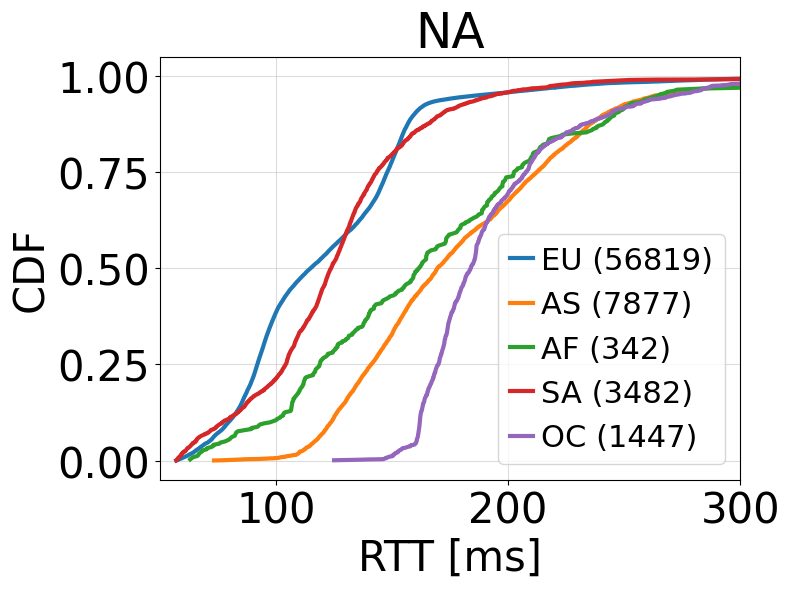

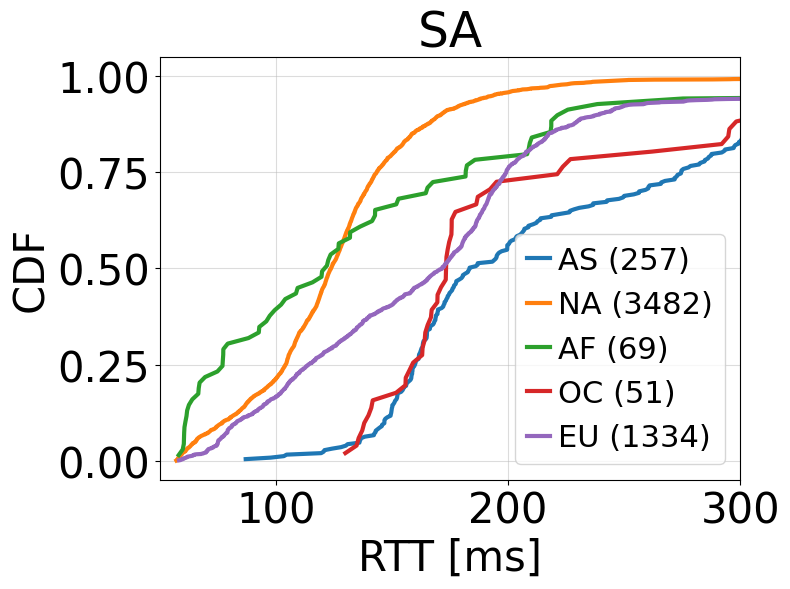

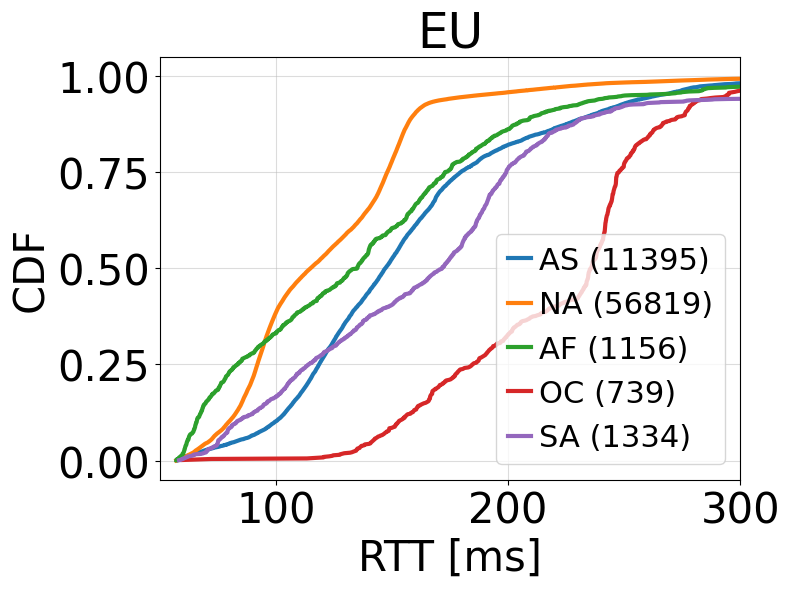

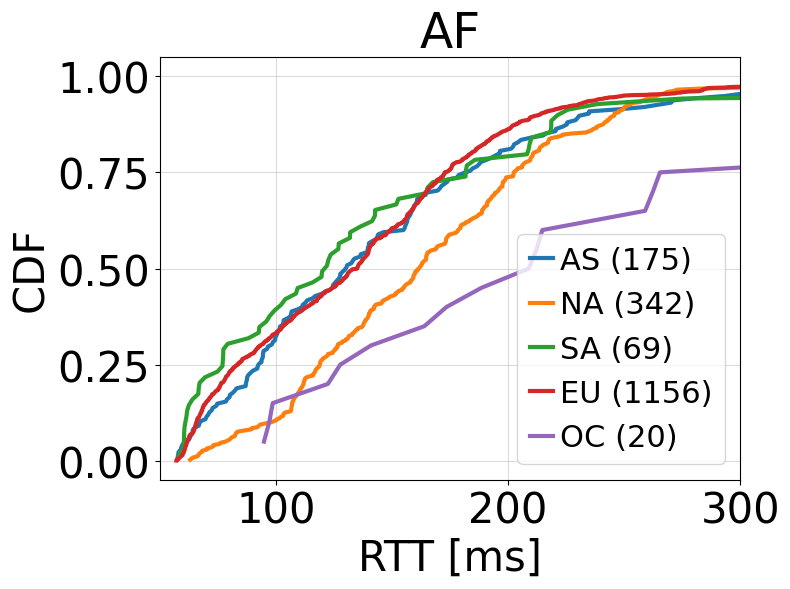

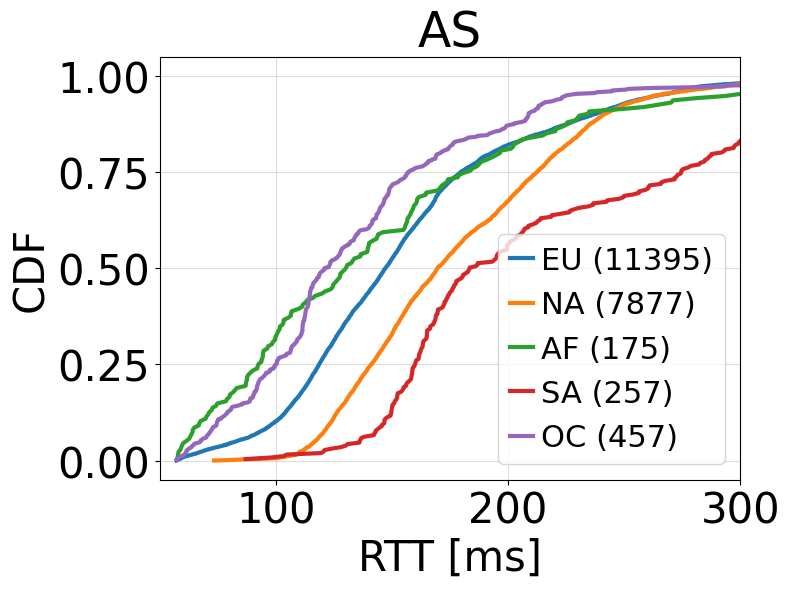

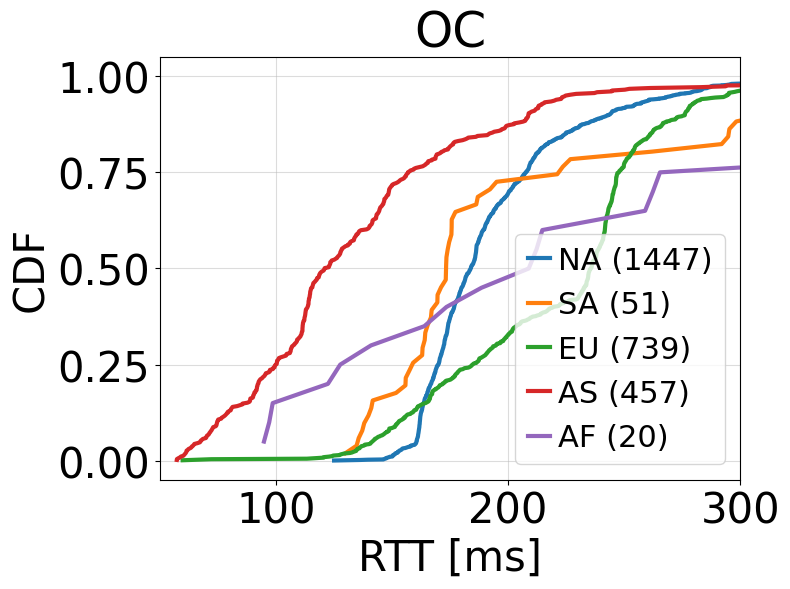

In [39]:
for src_cont in ["NA", "SA", "EU", "AF", "AS", "OC"]:
    
    fig, ax = plt.subplots(1, figsize=(8, 6), sharex=True, sharey=True)
    
    ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
    ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')

    markers = itertools.cycle(["o", "d", "s"])
    
    
    
    rtts = get_continent_rtts(G, src_cont)
    df = pd.DataFrame(rtts, columns=["cont", "rtt"])
    

    for cont in df.drop_duplicates("cont")["cont"].values:
    
        x, y = ecdf(df.loc[df["cont"] == cont]["rtt"])
        cont_label = cont.replace(f"-{src_cont}", "").replace(f"{src_cont}-", "")
        ax.plot(x, y, label=f'{cont_label} ({len(x)})', lw=3)
    
    
    ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=22,
              handletextpad=0.25, columnspacing=0.5, handlelength=0.75)
    
    ax.set_title(f"{src_cont}", fontsize=35)

    ax.set_xlim(50, 300)
    
    # ax.set_ylabel('CDF', fontsize=20)
    
    ax.set_xlabel('RTT [ms]', fontsize=30)
    ax.set_ylabel('CDF', fontsize=30)
        
    ax.tick_params(labelsize=30)
    
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    fig.savefig(f"figures/ulh-prevalence/lhl_dist_breakdown_{src_cont}.pdf")